# Оптимизация портфеля в модели Хестона

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from py_vollib_vectorized import vectorized_implied_volatility as implied_vol

In [12]:
# Parameters
# simulation dependent
S0 = 100.0             # asset price
T = 1.0                # time in years
r = 0.02               # risk-free rate
N = 252                # number of time steps in simulation
M = 1000               # number of simulations

# Heston dependent parameters
kappa = 3              # rate of mean reversion of variance under risk-neutral dynamics
theta = 0.20**2        # long-term mean of variance under risk-neutral dynamics
v0 = 0.25**2           # initial variance under risk-neutral dynamics
rho = 0.7              # correlation between returns and variances under risk-neutral dynamics
sigma = 0.6            # volatility of volatility

theta, v0

(0.04000000000000001, 0.0625)

In [13]:
def heston_model_sim(S0, v0, rho, kappa, theta, sigma,T, N, M):
    """
    Inputs:
     - S0, v0: initial parameters for asset and variance
     - rho   : correlation between asset returns and variance
     - kappa : rate of mean reversion in variance process
     - theta : long-term mean of variance process
     - sigma : vol of vol / volatility of variance process
     - T     : time of simulation
     - N     : number of time steps
     - M     : number of scenarios / simulations
    
    Outputs:
    - asset prices over time (numpy array)
    - variance over time (numpy array)
    """
    # initialise other parameters
    dt = T/N
    mu = np.array([0,0])
    cov = np.array([[1,rho],
                    [rho,1]])

    # arrays for storing prices and variances
    S = np.full(shape=(N+1,M), fill_value=S0)
    v = np.full(shape=(N+1,M), fill_value=v0)

    # sampling correlated brownian motions under risk-neutral measure
    Z = np.random.multivariate_normal(mu, cov, (N,M))

    for i in range(1,N+1):
        S[i] = S[i-1] * np.exp( (r - 0.5*v[i-1])*dt + np.sqrt(v[i-1] * dt) * Z[i-1,:,0] )
        v[i] = np.maximum(v[i-1] + kappa*(theta-v[i-1])*dt + sigma*np.sqrt(v[i-1]*dt)*Z[i-1,:,1],0)
    
    return S, v

In [14]:
rho_p = 0.98
rho_n = -0.98
S_p,v_p = heston_model_sim(S0, v0, rho_p, kappa, theta, sigma,T, N, M)
S_n,v_n = heston_model_sim(S0, v0, rho_n, kappa, theta, sigma,T, N, M)

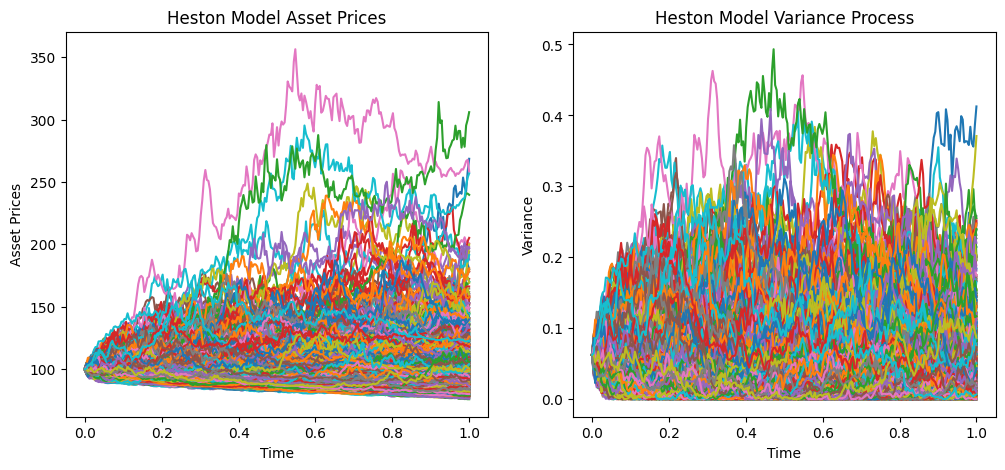

In [15]:
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(12,5))
time = np.linspace(0,T,N+1)
ax1.plot(time,S_p)
ax1.set_title('Heston Model Asset Prices')
ax1.set_xlabel('Time')
ax1.set_ylabel('Asset Prices')

ax2.plot(time,v_p)
ax2.set_title('Heston Model Variance Process')
ax2.set_xlabel('Time')
ax2.set_ylabel('Variance')

plt.show()

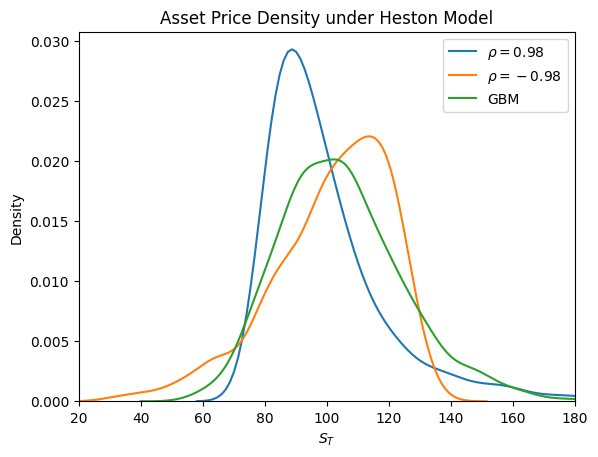

In [16]:
# simulate gbm process at time T
gbm = S0*np.exp( (r - theta**2/2)*T + np.sqrt(theta)*np.sqrt(T)*np.random.normal(0,1,M) )

fig, ax = plt.subplots()

ax = sns.kdeplot(S_p[-1], label=r"$\rho= 0.98$", ax=ax)
ax = sns.kdeplot(S_n[-1], label=r"$\rho= -0.98$", ax=ax)
ax = sns.kdeplot(gbm, label="GBM", ax=ax)

plt.title(r'Asset Price Density under Heston Model')
plt.xlim([20, 180])
plt.xlabel('$S_T$')
plt.ylabel('Density')
plt.legend()
plt.show()

/home/eugene/miniconda3/lib/python3.12/site-packages/py_vollib_vectorized/implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)


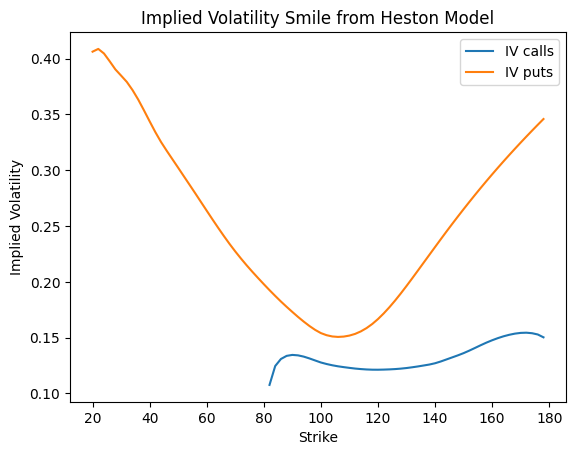

In [17]:
rho = -0.7
S,v = heston_model_sim(S0, v0, rho, kappa, theta, sigma,T, N, M)

# Set strikes and complete MC option price for different strikes
K = np.arange(20,180,2)

puts = np.array([np.exp(-r*T)*np.mean(np.maximum(k-S,0)) for k in K])
calls = np.array([np.exp(-r*T)*np.mean(np.maximum(S-k,0)) for k in K])

put_ivs = implied_vol(puts, S0, K, T, r, flag='p', q=0, return_as='numpy', on_error='ignore')
call_ivs = implied_vol(calls, S0, K, T, r, flag='c', q=0, return_as='numpy')

plt.plot(K, call_ivs, label=r'IV calls')
plt.plot(K, put_ivs, label=r'IV puts')

plt.ylabel('Implied Volatility')
plt.xlabel('Strike')

plt.title('Implied Volatility Smile from Heston Model')
plt.legend()
plt.show()

# Оптимизация портфеля в модели GARCH(1, 1)

In [36]:
from random import gauss
import matplotlib.pyplot as plt
import numpy as np
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_pacf

#### Сгенерируем данные для дальнейшего обучения модели GARCH

In [41]:
# Создадим датасет
n = 1000
omega = 0.5

alpha_1 = 0.1
alpha_2 = 0.2

beta_1 = 0.3
beta_2 = 0.4

test_size = int(n*0.25)

series = [gauss(0,1), gauss(0,1)]
vols = [1, 1]

for _ in range(n):
    new_vol = np.sqrt(omega + alpha_1*series[-1]**2 + alpha_2*series[-2]**2 + beta_1*vols[-1]**2 + beta_2*vols[-2]**2)
    new_val = gauss(0,1) * new_vol
    
    vols.append(new_vol)
    series.append(new_val)

Text(0.5, 1.0, 'Симулированные данные для модели GARCH(1, 1)')

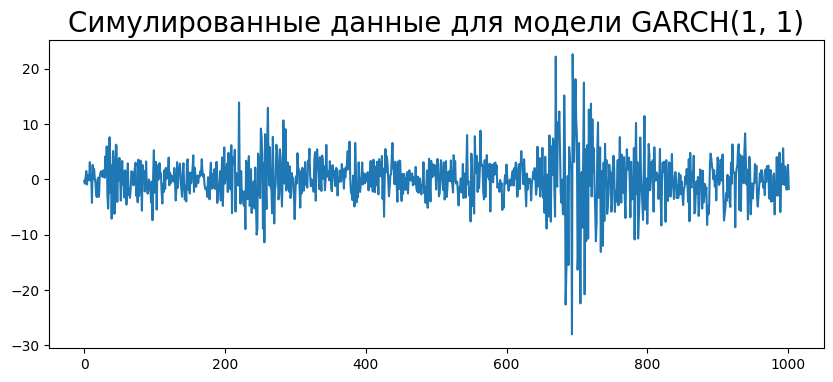

In [42]:
plt.figure(figsize=(10,4))
plt.plot(series)
plt.title('Симулированные данные для модели GARCH(1, 1)', fontsize=20)

Text(0.5, 1.0, 'Стандартные отклонения симулированных данных')

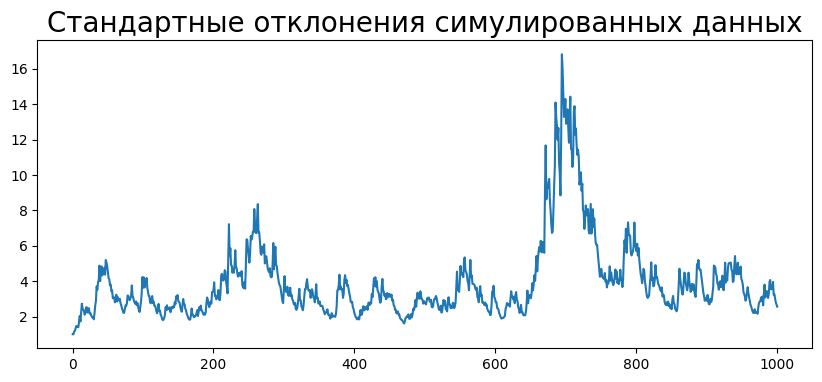

In [43]:
plt.figure(figsize=(10,4))
plt.plot(vols)
plt.title('Стандартные отклонения симулированных данных', fontsize=20)

#### Построим график PACF (частичная автокорреляция)

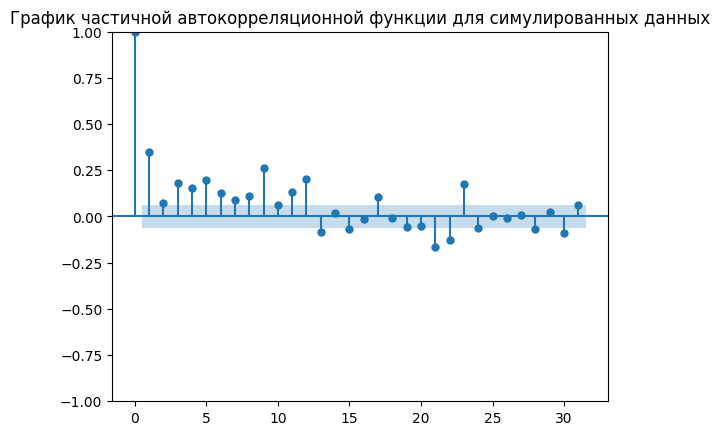

In [44]:
plot_pacf(np.array(series)**2)
plt.title('График частичной автокорреляционной функции для симулированных данных')
plt.show()

#### Обучим модель GARCH(1, 1)

In [68]:
train, test = series[:-test_size], series[-test_size:]

In [85]:
model = arch_model(train, p=1, q=1)

In [86]:

model_fit = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1682357583.325341
Iteration:      2,   Func. Count:     13,   Neg. LLF: 4699.254970772735
Iteration:      3,   Func. Count:     21,   Neg. LLF: 3425.6200198319684
Iteration:      4,   Func. Count:     28,   Neg. LLF: 2666.7083700340027
Iteration:      5,   Func. Count:     34,   Neg. LLF: 2661.0126070969773
Iteration:      6,   Func. Count:     40,   Neg. LLF: 2660.2878126759088
Iteration:      7,   Func. Count:     46,   Neg. LLF: 2659.544322691044
Iteration:      8,   Func. Count:     51,   Neg. LLF: 2659.5442362686676
Iteration:      9,   Func. Count:     55,   Neg. LLF: 2659.5442362688627
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2659.5442362686676
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9


In [87]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2659.54
Distribution:                  Normal   AIC:                           5327.09
Method:            Maximum Likelihood   BIC:                           5346.72
                                        No. Observations:                 1001
Date:                Sat, Jun 14 2025   Df Residuals:                     1000
Time:                        23:01:57   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.0245  9.095e-02      0.270      0.788 [ -0.154,  0.203]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.2699  8.610e-02      3.134  1.722e-03   [  0.101,  0.439]
alpha[1]       0.1268  1.889e-02      6.709  1.958e-11 [8.972e-02,  0.164]
beta[1]        0.8589  1.604e-02     53.532      0.000   [  0.827,  0.890]
==========================================================================

Covariance estimator: robust
"""

#### Сделаем предсказания для тестовой выборки и сравним графики волатильности (на горизонте в два дня)

In [88]:
predictions = model_fit.forecast(horizon=2)

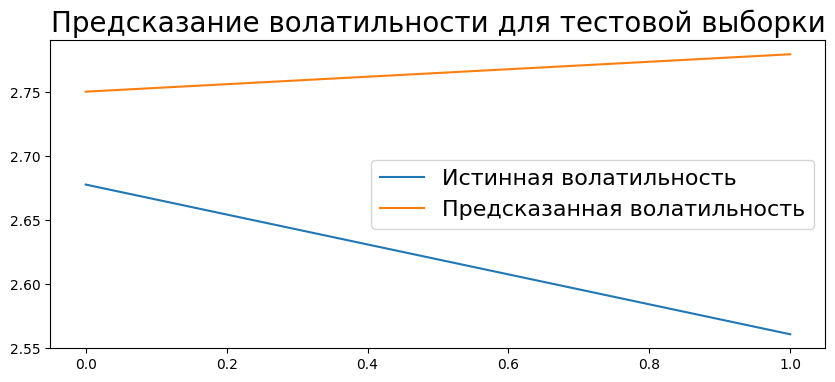

In [89]:
plt.figure(figsize=(10,4))
true, = plt.plot(vols[-2:])
preds, = plt.plot(np.sqrt(predictions.variance.values[-1, :]))
plt.title('Предсказание волатильности для тестовой выборки', fontsize=20)
plt.legend(['Истинная волатильность', 'Предсказанная волатильность'], fontsize=16)

In [76]:
rolling_predictions = []
for i in range(test_size):
    train = series[:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

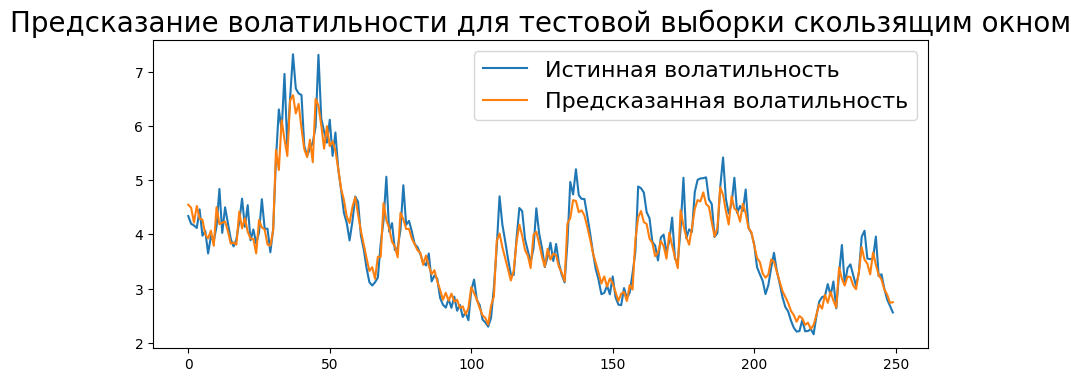

In [77]:
plt.figure(figsize=(10,4))
true, = plt.plot(vols[-test_size:])
preds, = plt.plot(rolling_predictions)
plt.title('Предсказание волатильности для тестовой выборки скользящим окном', fontsize=20)
plt.legend(['Истинная волатильность', 'Предсказанная волатильность'], fontsize=16)